# Polymarket Metadata Analysis

This notebook loads daily market data and LLM metadata, filters to valid metadata rows, and builds analysis plots plus a simple decision tree model.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.isotonic import IsotonicRegression
from pathlib import Path

daily_path = Path('polymarket_output/daily.csv')
meta_path = Path('polymarket_output/market_metadata.csv')

daily = pd.read_csv(daily_path)
meta = pd.read_csv(meta_path)
vol_path = Path('polymarket_output/daily_volumes.csv')
vol = pd.read_csv(vol_path)

# Keep only valid metadata rows
meta_ok = meta[meta['status'] == 'ok'].copy()
# Normalize type/domain to strings
meta_ok['type'] = meta_ok['type'].astype(str).str.replace('.0','', regex=False)
meta_ok['domain'] = meta_ok['domain'].astype(str)

# Join metadata into daily data
df = daily.merge(meta_ok, on='slug', how='inner', suffixes=('', '_meta'))
# Merge daily volumes
df = df.merge(vol, on=['market_id','date'], how='left', suffixes=('', '_vol'))
# Coerce daily volume + truncated flag
df['daily_volume'] = pd.to_numeric(df['daily_volume'], errors='coerce')
df['truncated'] = pd.to_numeric(df['truncated'], errors='coerce').fillna(0).astype(int)
df.loc[df['truncated'] == 1, 'daily_volume'] = -1
# Cumulative spend per market (treat truncated days as 0 for cumulative)
df['daily_volume_for_cum'] = df['daily_volume'].where(df['daily_volume'] >= 0, 0)
df = df.sort_values(['market_id','date'])
df['cumulative_spend'] = df.groupby('market_id')['daily_volume_for_cum'].cumsum()
# Daily change in yes_price (0 if no prior day)
df = df.sort_values(['market_id','date'])
df['delta_yes'] = df.groupby('market_id')['yes_price'].diff().fillna(0)

# Load market texts for titles/descriptions
texts = pd.read_csv('polymarket_output/market_texts.csv')
df = df.merge(texts[['slug','title','description']], on='slug', how='left', suffixes=('', '_text'))
if 'title_text' in df.columns:
    df['title'] = df['title'].fillna(df['title_text'])
if 'description_text' in df.columns:
    df['description'] = df['description'].fillna(df['description_text'])
df = df.drop(columns=['title_text','description_text'], errors='ignore')

# Parse dates
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['occurrence_or_deadline_ddmmyyyy'] = pd.to_datetime(df['occurrence_or_deadline_ddmmyyyy'], format='%d/%m/%Y', errors='coerce')

# Compute days left to occurrence/deadline
df['days_to_event'] = (df['occurrence_or_deadline_ddmmyyyy'] - df['date']).dt.days
# Drop post-event days (days_to_event < 0)
df = df[df['days_to_event'] >= 0]
# Forward-fill missing days per market (use last known yes_price)
# Build a complete daily index per market between min/max dates in df
def forward_fill_market(g):
    g = g.sort_values('date')
    g = g.drop_duplicates('date', keep='last')
    # Determine close date (closed_ts fallback end_date_ts)
    close_ts = g['closed_ts'].dropna()
    if len(close_ts) > 0:
        close_date = pd.to_datetime(close_ts.iloc[0], unit='s', errors='coerce')
    else:
        end_ts = g['end_date_ts'].dropna()
        close_date = pd.to_datetime(end_ts.iloc[0], unit='s', errors='coerce') if len(end_ts) > 0 else pd.NaT
    # Occurrence/deadline from metadata
    occ = g['occurrence_or_deadline_ddmmyyyy'].dropna()
    occ_date = occ.iloc[0] if len(occ) > 0 else pd.NaT
    # End date is the earlier of close vs occurrence/deadline (if both present)
    end_date = g['date'].max()
    if pd.notna(close_date) and pd.notna(occ_date):
        end_date = min(close_date, occ_date)
    elif pd.notna(close_date):
        end_date = max(end_date, close_date)
    elif pd.notna(occ_date):
        end_date = max(end_date, occ_date)
    idx = pd.date_range(g['date'].min(), end_date, freq='D')
    g = g.set_index('date').reindex(idx)
    g['market_id'] = g['market_id'].ffill().bfill()
    g['slug'] = g['slug'].ffill().bfill()
    g['yes_price'] = g['yes_price'].ffill()
    g['domain'] = g['domain'].ffill().bfill()
    g['type'] = g['type'].ffill().bfill()
    g['occurrence_or_deadline_ddmmyyyy'] = g['occurrence_or_deadline_ddmmyyyy'].ffill().bfill()
    g['final_outcome_proxy'] = g['final_outcome_proxy'].ffill().bfill()
    g['days_to_event'] = (g['occurrence_or_deadline_ddmmyyyy'] - g.index).dt.days
    g = g.reset_index().rename(columns={'index':'date'})
    return g

df = df.groupby('market_id', group_keys=False).apply(forward_fill_market)

# Keep a copy for histograms before modeling filters
df_all = df.copy()

# Filter for modeling rows only
df_model = df[df['days_to_event'].notna()].copy()
df_model = df_model[df_model['yes_price'].notna()]

# Normalize outcome to binary target
def outcome_to_int(x):
    if isinstance(x, str):
        x = x.strip().upper()
        if x in ('YES', 'Y', '1'):
            return 1
        if x in ('NO', 'N', '0'):
            return 0
    return np.nan

df_model['target'] = df_model['final_outcome_proxy'].apply(outcome_to_int)
df_model = df_model[df_model['target'].notna()]

# Per-row weight = 1 / L where L is length of market time series (after filtering)
len_by_market = df_model.groupby('market_id').size()
df_model['weight'] = df_model['market_id'].map(lambda m: 1.0 / len_by_market[m])

# Cast types
df_model['yes_price'] = df_model['yes_price'].astype(float)
df_model['total_volume'] = pd.to_numeric(df_model.get('total_volume', pd.Series()), errors='coerce')

# Build a complete daily index per market between min/max dates in df


/var/folders/9p/9f8bc3xn0r7bqrkntsyyvmv80000gn/T/ipykernel_13548/1748455407.py:90: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('market_id', group_keys=False).apply(forward_fill_market)


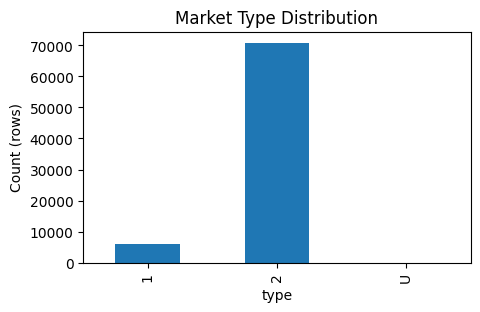

In [2]:
# Histogram: Type 1 vs Type 2
type_counts = df_all['type'].value_counts().reindex(['1','2','U']).fillna(0)
plt.figure(figsize=(5,3))
type_counts.plot(kind='bar')
plt.title('Market Type Distribution')
plt.ylabel('Count (rows)')
plt.show()

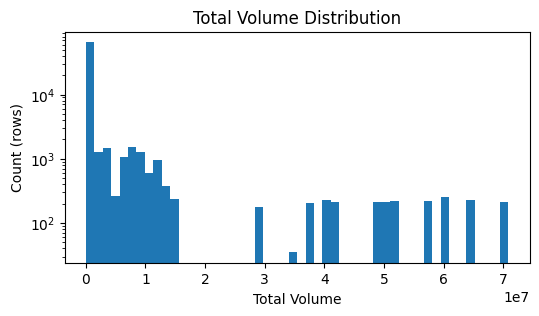

In [3]:
# Histogram: Volume (log scale for readability)
plt.figure(figsize=(6,3))
vol = df_all['total_volume'].dropna()
plt.hist(vol, bins=50)
plt.title('Total Volume Distribution')
plt.xlabel('Total Volume')
plt.ylabel('Count (rows)')
plt.yscale('log')
plt.show()

In [4]:
# Titles at volume quantiles (3 unique markets each)
q = [0, 0.25, 0.5, 0.75, 0.9, 1.0]
vol_series = df_all[['slug','title','total_volume']].dropna()
vol_series['total_volume'] = pd.to_numeric(vol_series['total_volume'], errors='coerce')
vol_series = vol_series.dropna()
# One row per market
vol_series = vol_series.groupby('slug', as_index=False).first()
quantiles = vol_series['total_volume'].quantile(q)
rows = []
for qi, qv in quantiles.items():
    closest = vol_series.assign(dist=(vol_series['total_volume'] - qv).abs()).nsmallest(3, 'dist')
    for _, row in closest.iterrows():
        rows.append({
            'quantile': qi,
            'volume': row['total_volume'],
            'slug': row['slug'],
            'title': row['title'],
        })

display(pd.DataFrame(rows))


,quantile,volume,slug,title
0,0.00,5.000000e+00,cfb-2025-26-doak-walker-award-winner-justice-h...,Will Justice Haynes win the 2025–2026 Doak Wal...
1,0.00,5.000000e+00,crint-pak-aus-2026-02-01-most-sixes-pak,International T20 Series: Pakistan vs Australi...
2,0.00,5.000000e+00,nba-2k26-metascore-90,NBA 2K26 Metascore 90+
3,0.25,1.521950e+03,will-bill-belichick-be-the-next-atlanta-falcon...,Will Bill Belichick be the next Atlanta Falcon...
4,0.25,1.516988e+03,will-mike-mccarthy-be-the-next-baltimore-raven...,Will Mike McCarthy be the next Baltimore Raven...
5,0.25,1.511950e+03,will-ejiro-evero-be-the-next-atlanta-falcons-h...,Will Ejiro Evero be the next Atlanta Falcons H...
6,0.50,8.082403e+03,highest-temperature-in-ankara-on-february-4-20...,Will the highest temperature in Ankara be 3°C ...
7,0.50,8.003500e+03,will-leavitt-say-fed-or-federal-reserve-during...,"Will Leavitt say ""Fed"" or ""Federal Reserve"" du..."
8,0.50,8.001779e+03,rou1-fmb-fcm-2026-02-04-fcm,Will FK Csíkszereda Miercurea Ciuc win on 2026...
9,0.75,3.975442e+04,seeker-fdv-above-150m-one-day-after-launch,Seeker FDV above $150M one day after launch?


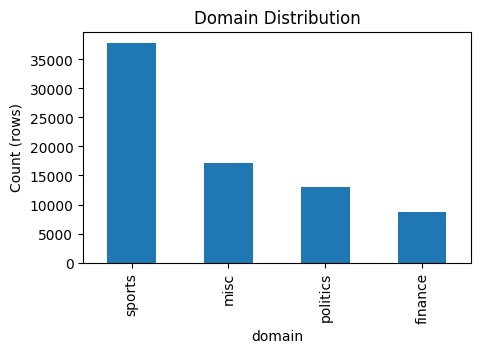

In [5]:
# Histogram: Domain
domain_counts = df_all['domain'].value_counts()
plt.figure(figsize=(5,3))
domain_counts.plot(kind='bar')
plt.title('Domain Distribution')
plt.ylabel('Count (rows)')
plt.show()

In [6]:
# Sample 3 examples from each domain
samples = []
for dom in ['finance','sports','politics','misc']:
    subset = df_all[df_all['domain'] == dom]
    if len(subset) == 0:
        continue
    samp = subset[['slug','title','occurrence_or_deadline_ddmmyyyy','type']].sample(min(3, len(subset)), random_state=0)
    samp['domain'] = dom
    samples.append(samp)

if samples:
    out = pd.concat(samples)
    display(out.reset_index(drop=True))
else:
    print('No samples available.')


,slug,title,occurrence_or_deadline_ddmmyyyy,type,domain
0,will-theo-launch-a-token-by-december-31-2025,Will Theo launch a token by December 31 2025?,2025-12-31,2,finance
1,harmonix-fdv-above-100m-one-day-after-launch-2...,Harmonix FDV above $100M one day after launch?,2026-12-31,2,finance
2,will-bnb-dip-to-700-by-december-31-2026,Will BNB dip to $700 by December 31 2026?,2026-12-31,2,finance
3,will-mirra-andreeva-win-a-calendar-grand-slam-...,Will Mirra Andreeva win a Calendar Grand Slam ...,2026-12-31,2,sports
4,will-the-indianapolis-colts-win-super-bowl-2026,Will the Indianapolis Colts win Super Bowl 2026?,2026-12-31,2,sports
5,will-the-buffalo-bills-win-super-bowl-2026,Will the Buffalo Bills win Super Bowl 2026?,2026-12-31,2,sports
6,maduro-out-by-december-31-2026-334-766,Maduro out by December 31 2026?,2026-12-31,2,politics
7,duplicate-will-tulsi-gabbard-be-the-first-to-l...,duplicate Will Tulsi Gabbard be the first to l...,2026-12-31,2,politics
8,will-any-state-eliminate-mail-in-votingvoting-...,Will Trump act to ban mail-in voting or voting...,2025-12-31,2,politics
9,will-if-i-had-legs-id-kick-you-win-best-origin...,Will If I Had Legs I'd Kick You win Best Origi...,2026-06-30,2,misc


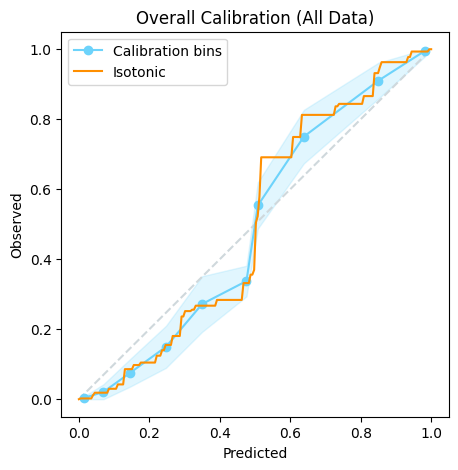

In [7]:
# Overall calibration (no splits, weighted)
def merge_bins_equal_width_weighted(probs, outs, weights, n_bins=20, min_weight=100):
    edges = [i / n_bins for i in range(n_bins + 1)]
    bins = [[] for _ in range(n_bins)]
    for p, o, w in zip(probs, outs, weights):
        p = min(max(float(p), 0.0), 1.0)
        idx = min(int(p * n_bins), n_bins - 1)
        bins[idx].append((p, o, w))
    weights_by_bin = [sum(bi[2] for bi in b) for b in bins]
    i = 0
    while i < len(weights_by_bin):
        if weights_by_bin[i] >= min_weight or i == len(weights_by_bin) - 1:
            i += 1
            continue
        weights_by_bin[i+1] += weights_by_bin[i]
        del weights_by_bin[i]
        del edges[i+1]
    merged = [[] for _ in range(len(edges) - 1)]
    for p, o, w in zip(probs, outs, weights):
        p = min(max(float(p), 0.0), 1.0)
        for j in range(len(edges) - 1):
            if (p >= edges[j]) and (p < edges[j+1] or j == len(edges)-2):
                merged[j].append((p, o, w))
                break
    xs, ys, lo, hi = [], [], [], []
    for b in merged:
        if not b:
            continue
        ps = [x for x,_,_ in b]
        os = [y for _,y,_ in b]
        ws = [w for _,_,w in b]
        wsum = sum(ws)
        pbar = sum(p*w for p, w in zip(ps, ws)) / wsum
        ybar = sum(o*w for o, w in zip(os, ws)) / wsum
        se = (ybar*(1-ybar)/wsum)**0.5
        xs.append(pbar)
        ys.append(ybar)
        lo.append(max(0, ybar - 1.96*se))
        hi.append(min(1, ybar + 1.96*se))
    return xs, ys, lo, hi

sub = df_model[df_model['target'].isin([0,1])]
probs = sub['yes_price'].astype(float).values
outs = sub['target'].astype(int).values
weights = sub['weight'].astype(float).values
xs, ys, lo, hi = merge_bins_equal_width_weighted(probs, outs, weights, n_bins=20, min_weight=100)
iso = IsotonicRegression(out_of_bounds='clip')
iso.fit(probs, outs, sample_weight=weights)
grid = np.linspace(0, 1, 200)
iso_pred = iso.predict(grid)

plt.figure(figsize=(5,5))
plt.plot([0,1],[0,1],'--', color='#cfd8dc')
plt.plot(xs, ys, marker='o', color='#6dd3fb', label='Calibration bins')
plt.fill_between(xs, lo, hi, color='#6dd3fb', alpha=0.2)
plt.plot(grid, iso_pred, color='#ff8f00', label='Isotonic')
plt.title('Overall Calibration (All Data)')
plt.xlabel('Predicted')
plt.ylabel('Observed')
plt.legend()
plt.show()


In [8]:
# Build dataset for decision tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# Features
features = df_model[['yes_price','delta_yes','days_to_event','daily_volume','cumulative_spend','type','domain']].copy()
features = pd.get_dummies(features, columns=['domain'], drop_first=False)
X = features.fillna(0)
y = df_model['target'].astype(int)

# Train decision tree (all rows used; no test split requested)
clf = DecisionTreeClassifier(min_samples_leaf=500, random_state=0)
clf.fit(X, y)

X.head()

,yes_price,delta_yes,days_to_event,daily_volume,cumulative_spend,type,domain_finance,domain_misc,domain_politics,domain_sports
1,0.185,0.00,356,-1.0,0.0,2,True,False,False,False
2,0.185,0.00,355,-1.0,0.0,2,True,False,False,False
3,0.195,0.01,354,-1.0,0.0,2,True,False,False,False
4,0.195,0.00,353,-1.0,0.0,2,True,False,False,False
5,0.195,0.00,352,-1.0,0.0,2,True,False,False,False


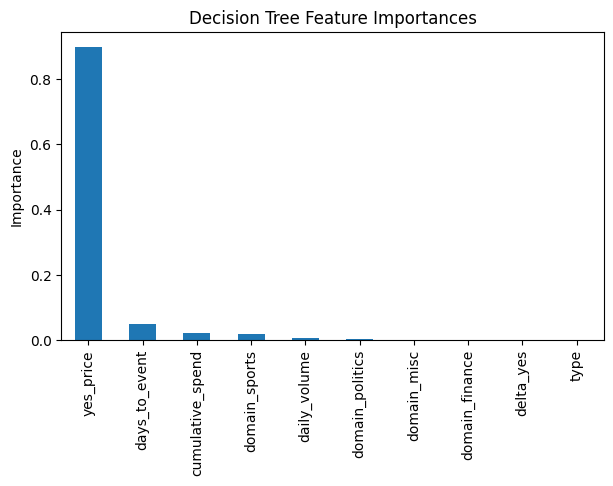

In [9]:
# Plot feature importances
importances = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(7,4))
importances.plot(kind='bar')
plt.title('Decision Tree Feature Importances')
plt.ylabel('Importance')
plt.show()

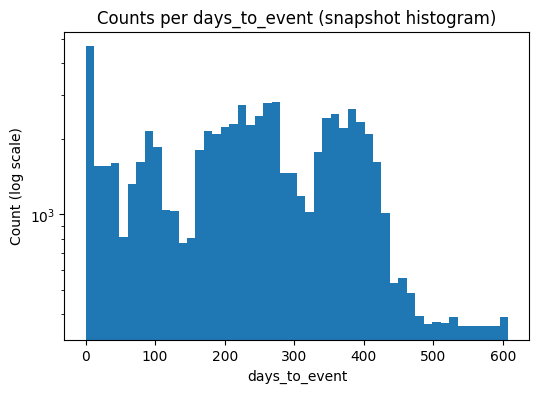

days_to_event
0      691
1      688
2      522
3      474
4      432
5      397
6      286
273    286
272    286
271    286
Name: count, dtype: int64

In [10]:
# Snapshot counts: how many data points at each days_to_event value
counts = df_model['days_to_event'].value_counts().sort_index()

plt.figure(figsize=(6,4))
plt.hist(df_model['days_to_event'].dropna(), bins=50)
plt.yscale('log')
plt.title('Counts per days_to_event (snapshot histogram)')
plt.xlabel('days_to_event')
plt.ylabel('Count (log scale)')
plt.show()

# Show top snapshots with most data points
top = counts.sort_values(ascending=False).head(10)
display(top)


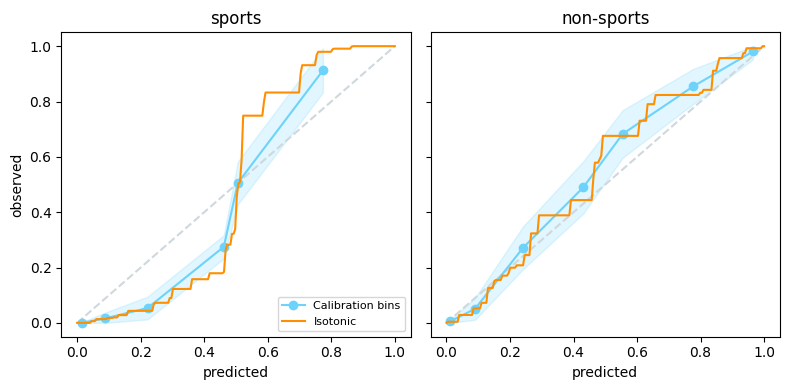

In [11]:
# Calibration grid by sports vs non-sports (weighted)
domains = ['sports','non-sports']
fig, axes = plt.subplots(1, len(domains), figsize=(8,4), sharex=True, sharey=True)
for j, dom in enumerate(domains):
    ax = axes[j]
    if dom == 'sports':
        sub = df_model[df_model['domain'] == 'sports']
    else:
        sub = df_model[df_model['domain'] != 'sports']
    sub = sub[sub['target'].isin([0,1])]
    if sub.empty:
        ax.set_title(f'{dom} (no data)')
        ax.plot([0,1],[0,1],'--', color='#cfd8dc')
        continue
    probs = sub['yes_price'].astype(float).values
    outs = sub['target'].astype(int).values
    len_by_market = sub.groupby('market_id').size()
    weights = sub['market_id'].map(lambda m: 1.0 / len_by_market[m]).astype(float).values
    xs, ys, lo, hi = merge_bins_equal_width_weighted(probs, outs, weights, n_bins=20, min_weight=100)
    iso = IsotonicRegression(out_of_bounds='clip')
    iso.fit(probs, outs, sample_weight=weights)
    grid = np.linspace(0, 1, 200)
    iso_pred = iso.predict(grid)
    ax.plot([0,1],[0,1],'--', color='#cfd8dc')
    ax.plot(xs, ys, marker='o', color='#6dd3fb', label='Calibration bins')
    ax.plot(grid, iso_pred, color='#ff8f00', label='Isotonic')
    if xs:
        ax.fill_between(xs, lo, hi, color='#6dd3fb', alpha=0.2)
    ax.set_title(dom)
    ax.set_xlabel('predicted')
    if j == 0:
        ax.set_ylabel('observed')
        ax.legend(loc='lower right', fontsize=8)
plt.tight_layout()
plt.show()


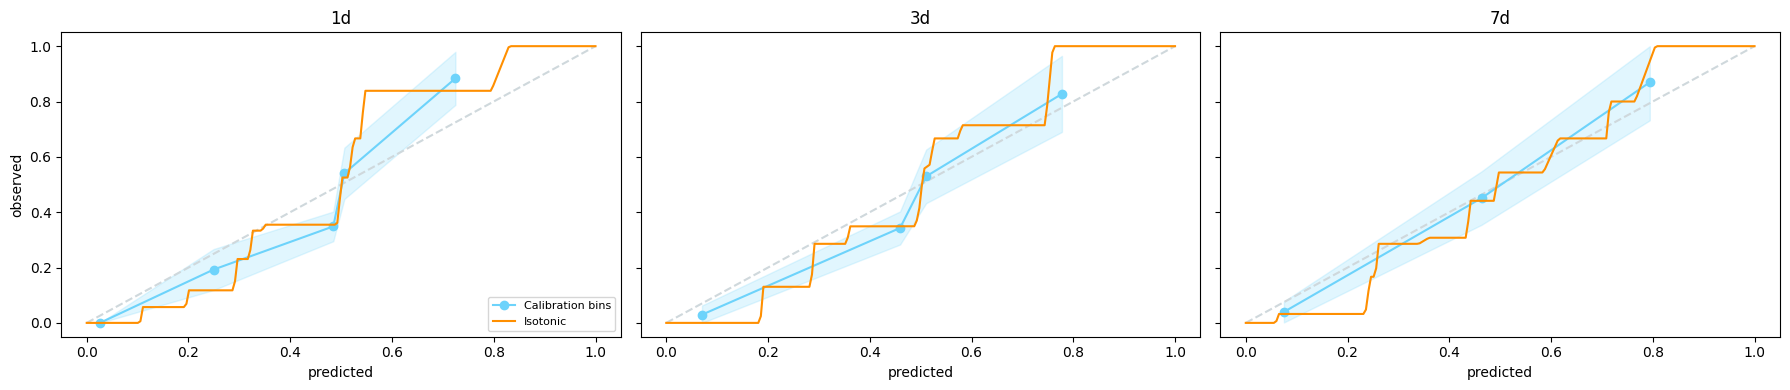

In [12]:
# Calibration grid by days_to_event only (weighted)
ranges = [(1,1), (3,3), (7,7)]
fig, axes = plt.subplots(1, len(ranges), figsize=(18,4), sharex=True, sharey=True)
for j, (a,b) in enumerate(ranges):
    ax = axes[j]
    sub = df_model[(df_model['days_to_event'] >= a) & (df_model['days_to_event'] <= b)]
    sub = sub[sub['target'].isin([0,1])]
    if sub.empty:
        ax.set_title(f'{a}-{b}d (no data)')
        ax.plot([0,1],[0,1],'--', color='#cfd8dc')
        continue
    probs = sub['yes_price'].astype(float).values
    outs = sub['target'].astype(int).values
    # Slice-specific weights: 1 / S where S is series length within slice
    len_by_market = sub.groupby('market_id').size()
    weights = sub['market_id'].map(lambda m: 1.0 / len_by_market[m]).astype(float).values
    xs, ys, lo, hi = merge_bins_equal_width_weighted(probs, outs, weights, n_bins=20, min_weight=100)
    iso = IsotonicRegression(out_of_bounds='clip')
    iso.fit(probs, outs, sample_weight=weights)
    grid = np.linspace(0, 1, 200)
    iso_pred = iso.predict(grid)
    ax.plot([0,1],[0,1],'--', color='#cfd8dc')
    ax.plot(xs, ys, marker='o', color='#6dd3fb', label='Calibration bins')
    ax.plot(grid, iso_pred, color='#ff8f00', label='Isotonic')
    if xs:
        ax.fill_between(xs, lo, hi, color='#6dd3fb', alpha=0.2)
    ax.set_title(f'{a}d')
    ax.set_xlabel('predicted')
    if j == 0:
        ax.set_ylabel('observed')
        ax.legend(loc='lower right', fontsize=8)
plt.tight_layout()
plt.show()


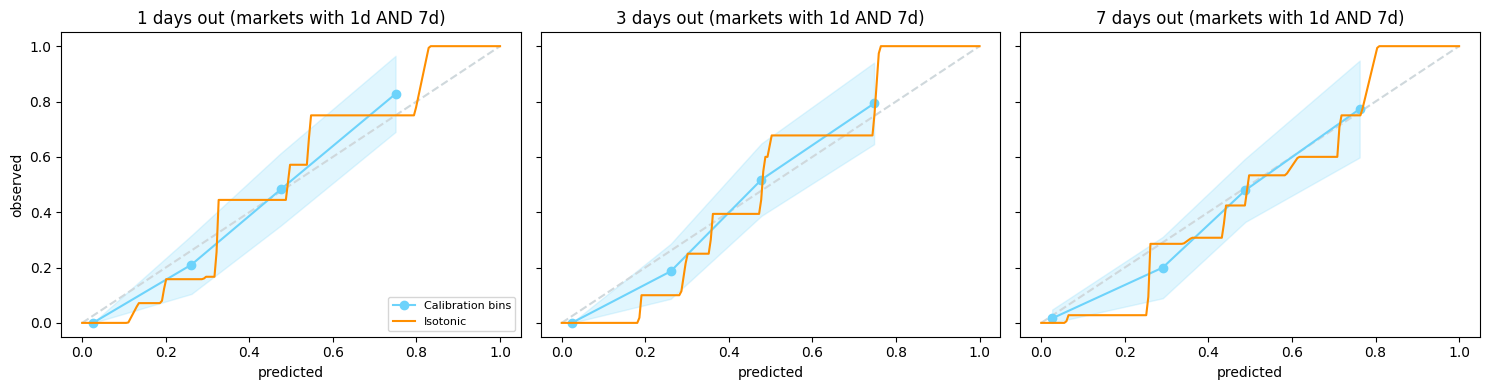

In [13]:
# Calibration at 1d/3d/7d for markets that reach BOTH 1d and 7d
snapshots = [1, 3, 7]
# markets that have at least one row at 1 day out
markets_1d = set(df_model[df_model['days_to_event'] == 1]['market_id'])
markets_7d = set(df_model[df_model['days_to_event'] == 7]['market_id'])
markets_both = markets_1d & markets_7d

fig, axes = plt.subplots(1, len(snapshots), figsize=(15,4), sharex=True, sharey=True)
for j, d in enumerate(snapshots):
    ax = axes[j]
    sub = df_model[(df_model['market_id'].isin(markets_both)) & (df_model['days_to_event'] == d)]
    sub = sub[sub['target'].isin([0,1])]
    if sub.empty:
        ax.set_title(f'{d}d (no data)')
        ax.plot([0,1],[0,1],'--', color='#cfd8dc')
        continue
    probs = sub['yes_price'].astype(float).values
    outs = sub['target'].astype(int).values
    # slice-specific weights: 1/S within this snapshot
    len_by_market = sub.groupby('market_id').size()
    weights = sub['market_id'].map(lambda m: 1.0 / len_by_market[m]).astype(float).values
    xs, ys, lo, hi = merge_bins_equal_width_weighted(probs, outs, weights, n_bins=20, min_weight=50)
    iso = IsotonicRegression(out_of_bounds='clip')
    iso.fit(probs, outs, sample_weight=weights)
    grid = np.linspace(0, 1, 200)
    iso_pred = iso.predict(grid)
    ax.plot([0,1],[0,1],'--', color='#cfd8dc')
    ax.plot(xs, ys, marker='o', color='#6dd3fb', label='Calibration bins')
    ax.plot(grid, iso_pred, color='#ff8f00', label='Isotonic')
    if xs:
        ax.fill_between(xs, lo, hi, color='#6dd3fb', alpha=0.2)
    ax.set_title(f'{d} days out (markets with 1d AND 7d)')
    ax.set_xlabel('predicted')
    if j == 0:
        ax.set_ylabel('observed')
        ax.legend(loc='lower right', fontsize=8)

plt.tight_layout()
plt.show()


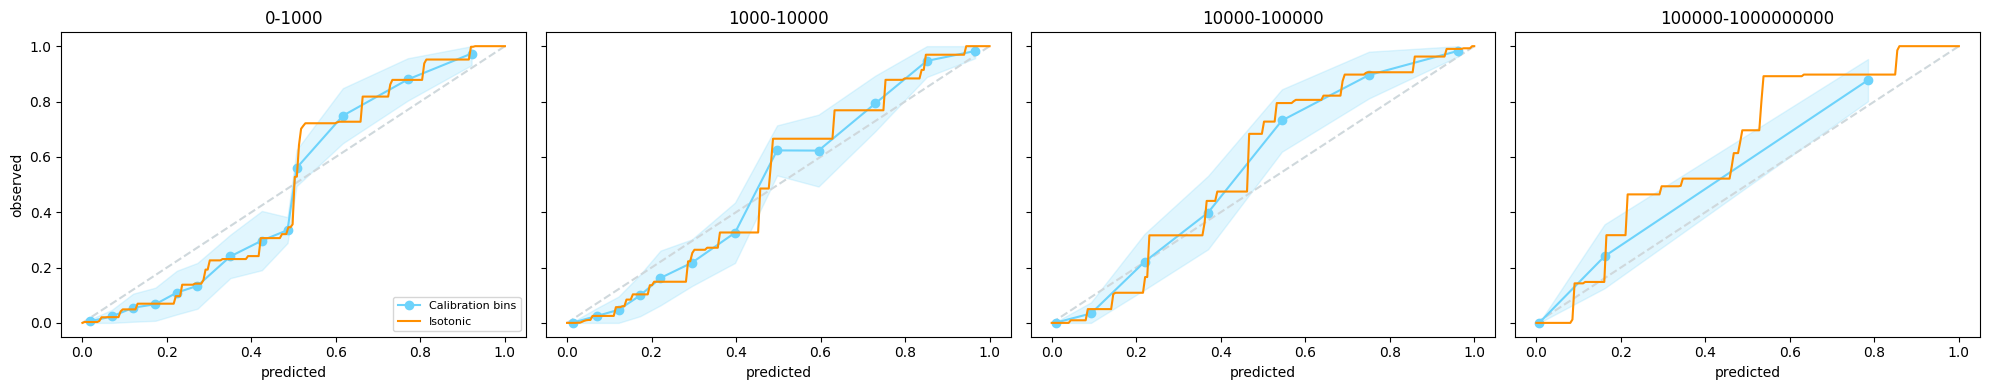

In [14]:
# Calibration grid by cumulative spend only (weighted)
spend_bins = [(0, 1e3), (1e3, 1e4), (1e4, 1e5), (1e5, 1e9)]
fig, axes = plt.subplots(1, len(spend_bins), figsize=(20,4), sharex=True, sharey=True)
for j, (a,b) in enumerate(spend_bins):
    ax = axes[j]
    sub = df_model[(df_model['cumulative_spend'] >= a) & (df_model['cumulative_spend'] < b)]
    sub = sub[sub['target'].isin([0,1])]
    if sub.empty:
        ax.set_title(f'{a:.0f}-{b:.0f} (no data)')
        ax.plot([0,1],[0,1],'--', color='#cfd8dc')
        continue
    probs = sub['yes_price'].astype(float).values
    outs = sub['target'].astype(int).values
    # Slice-specific weights: 1 / S where S is series length within slice
    len_by_market = sub.groupby('market_id').size()
    weights = sub['market_id'].map(lambda m: 1.0 / len_by_market[m]).astype(float).values
    xs, ys, lo, hi = merge_bins_equal_width_weighted(probs, outs, weights, n_bins=20, min_weight=50)
    iso = IsotonicRegression(out_of_bounds='clip')
    iso.fit(probs, outs, sample_weight=weights)
    grid = np.linspace(0, 1, 200)
    iso_pred = iso.predict(grid)
    ax.plot([0,1],[0,1],'--', color='#cfd8dc')
    ax.plot(xs, ys, marker='o', color='#6dd3fb', label='Calibration bins')
    ax.plot(grid, iso_pred, color='#ff8f00', label='Isotonic')
    if xs:
        ax.fill_between(xs, lo, hi, color='#6dd3fb', alpha=0.2)
    ax.set_title(f'{a:.0f}-{b:.0f}')
    ax.set_xlabel('predicted')
    if j == 0:
        ax.set_ylabel('observed')
        ax.legend(loc='lower right', fontsize=8)
plt.tight_layout()
plt.show()


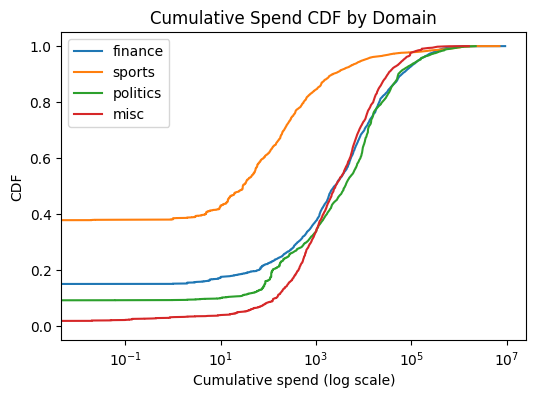

In [15]:
# CDF of cumulative spend by domain
plt.figure(figsize=(6,4))
domains = ['finance','sports','politics','misc']
for dom in domains:
    sub = df_model[df_model['domain'] == dom]
    if sub.empty:
        continue
    vals = sub['cumulative_spend'].dropna().sort_values()
    if len(vals) < 2:
        continue
    y = np.arange(1, len(vals)+1) / len(vals)
    plt.plot(vals.values, y, label=dom)
plt.xscale('log')
plt.title('Cumulative Spend CDF by Domain')
plt.xlabel('Cumulative spend (log scale)')
plt.ylabel('CDF')
plt.legend()
plt.show()
